**Endangered Species Image Classification Using Deep Learning**

**Objective**

The aim of this project is to develop a deep learning model using image classification to identify endangered species from images. By training a model on labeled species images, we seek to understand the visual features that help distinguish endangered animals from non-endangered ones. The project also uses Grad-CAM to interpret model predictions.

**Step 1:**

Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

**Step 2:**

Load and Prepare the Dataset

In [2]:
# Load metadata CSV
df = pd.read_csv('rare_species_data.csv')
# Strip whitespace from file paths
df['file_name'] = df['file_name'].str.strip()
# Ensure label column is string (as required by ImageDataGenerator)
df['is_endangered'] = df['is_endangered'].astype(str)
# Display sample data
df.head()

,rarespecies_id,eol_content_id,eol_page_id,kingdom,phylum,class,order,family,genus,species,sciName,common,file_name,is_endangered
0,75fd91cb-2881-41cd-88e6-de451e8b60e2,12853737,449393,Animalia,Mollusca,Bivalvia,Unionida,Unionidae,Cyclonaias,tuberculata,Cyclonaias tuberculata,purple wartyback,dataset/Animalia-Mollusca-Bivalvia-Unionida-Un...,0
1,28c508bc-63ff-4e60-9c8f-1934367e1528,20969394,793083,Animalia,Chordata,Reptilia,Testudines,Geoemydidae,Pangshura,sylhetensis,Pangshura sylhetensis,Assam Roofed Turtle,dataset/Animalia-Chordata-Reptilia-Testudines-...,1
2,00372441-588c-4af8-9665-29bee20822c0,28895411,319982,Animalia,Chordata,Amphibia,Caudata,Cryptobranchidae,Andrias,japonicus,Andrias japonicus,Japanese Giant Salamander,dataset/Animalia-Chordata-Amphibia-Caudata-Cry...,1
3,29cc6040-6af2-49ee-86ec-ab7d89793828,29658536,45510188,Animalia,Chordata,Aves,Passeriformes,Turdidae,Myadestes,obscurus,Myadestes obscurus,'Oma'o,dataset/Animalia-Chordata-Aves-Passeriformes-T...,0
4,94004bff-3a33-4758-8125-bf72e6e57eab,21252576,7250886,Animalia,Chordata,Mammalia,Primates,Indriidae,Propithecus,deckenii,Propithecus deckenii,Van der Decken's Sifaka,dataset/Animalia-Chordata-Mammalia-Primates-In...,1


**Dataset Overview**

In [3]:
# Dataset shape
print("Shape:", df.shape)

Shape: (11983, 14)


In [4]:
# Info about datatypes and non-nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11983 entries, 0 to 11982
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   rarespecies_id  11983 non-null  object
 1   eol_content_id  11983 non-null  int64 
 2   eol_page_id     11983 non-null  int64 
 3   kingdom         11983 non-null  object
 4   phylum          11983 non-null  object
 5   class           11983 non-null  object
 6   order           11983 non-null  object
 7   family          11983 non-null  object
 8   genus           11983 non-null  object
 9   species         11983 non-null  object
 10  sciName         11983 non-null  object
 11  common          11983 non-null  object
 12  file_name       11983 non-null  object
 13  is_endangered   11983 non-null  object
dtypes: int64(2), object(12)
memory usage: 1.3+ MB


In [5]:
# Basic stats for numerical columns
df.describe()

,eol_content_id,eol_page_id
count,1.198300e+04,1.198300e+04
mean,2.297681e+07,2.112247e+07
std,6.999289e+06,2.241319e+07
min,4.750000e+02,1.180080e+05
25%,2.058937e+07,7.954560e+05
50%,2.251368e+07,2.865857e+06
75%,2.932887e+07,4.551773e+07
max,3.061946e+07,5.269200e+07


In [6]:
 # Check for Missing Values
# Missing value summary
missing = df.isnull().sum()
missing[missing > 0]

Series([], dtype: int64)

### Class Distribution: Endangered vs Non-Endangered Species

In this section, we analyze the class balance of the target variable `is_endangered`, which indicates whether a species is endangered (`1`) or not (`0`).

#### What this does:
1. Displays the count of endangered and non-endangered samples using `value_counts()`.
2. Plots a bar chart using `seaborn.countplot` to visually show the class distribution.

#### Why it's useful:
- Helps identify if the dataset is **imbalanced** (i.e., significantly more samples in one class than the other).
- Imbalanced data can impact model performance, and may require strategies such as:
  - Resampling (oversampling/undersampling)
  - Using class weights during training

is_endangered
0    6974
1    5009
Name: count, dtype: int64


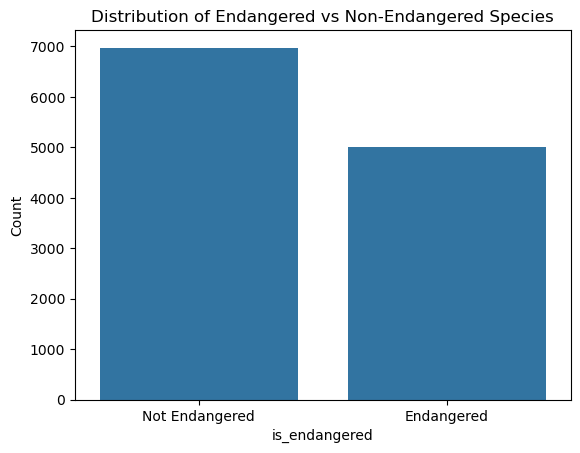

In [7]:
import seaborn as sns
# Value counts
print(df['is_endangered'].value_counts())

# Visualize class balance
sns.countplot(x='is_endangered', data=df)
plt.title('Distribution of Endangered vs Non-Endangered Species')
plt.xticks([0,1], ['Not Endangered', 'Endangered'])
plt.ylabel('Count')
plt.show()

### Endangerment Status of Top 10 Most Common Species

In this section, we visualize the distribution of endangered and non-endangered records for the top 10 most frequently occurring scientific names in the dataset.

#### What this does:
1. Identifies the top 10 most common `sciName` entries using `value_counts()`.
2. Filters the dataset to include only those species.
3. Plots a bar chart using `seaborn.countplot`, grouped by `is_endangered`.

#### Why it's useful:
- Highlights which of the most observed species are frequently listed as endangered.
- Helps uncover patterns in the dataset’s label distribution.
- Great for class imbalance analysis among highly represented species.

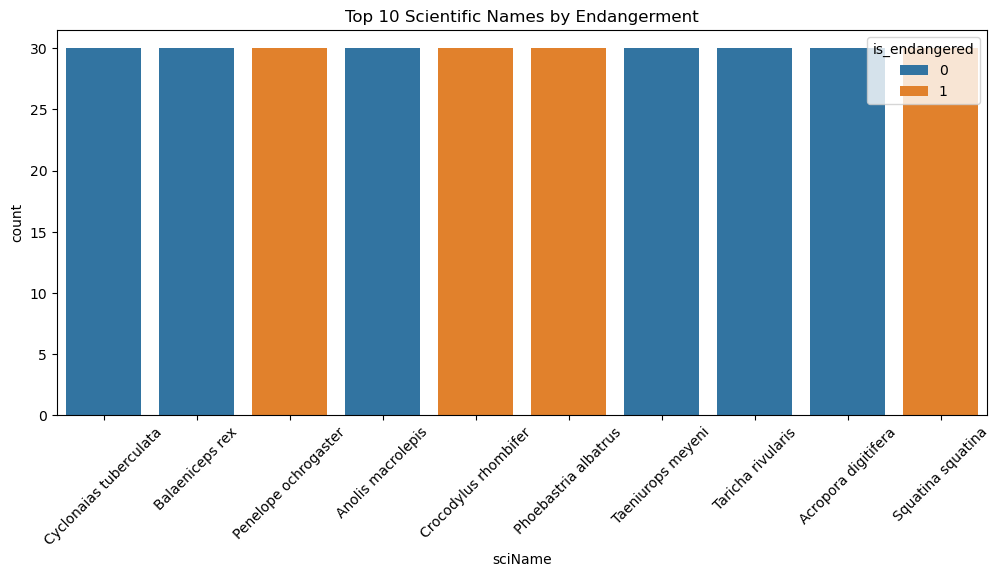

In [8]:
top_species = df['sciName'].value_counts().head(10).index.tolist()
top_species_df = df[df['sciName'].isin(top_species)]

plt.figure(figsize=(12, 5))
sns.countplot(data=top_species_df, x='sciName', hue='is_endangered')
plt.title("Top 10 Scientific Names by Endangerment")
plt.xticks(rotation=45)
plt.show()


### Correlation Heatmap of Numerical Features

In this section, we explore the correlation between numerical columns in the dataset. This can help identify relationships between features and detect redundancy or multicollinearity.

- We first extract only the numerical columns using `select_dtypes(include='number')`.
- Then, we compute the correlation matrix.
- Finally, we visualize the correlations using a heatmap from `seaborn`.

The heatmap provides a visual overview of how strongly features are correlated with each other. Correlation values range from -1 (perfect negative) to +1 (perfect positive), with 0 indicating no correlation.


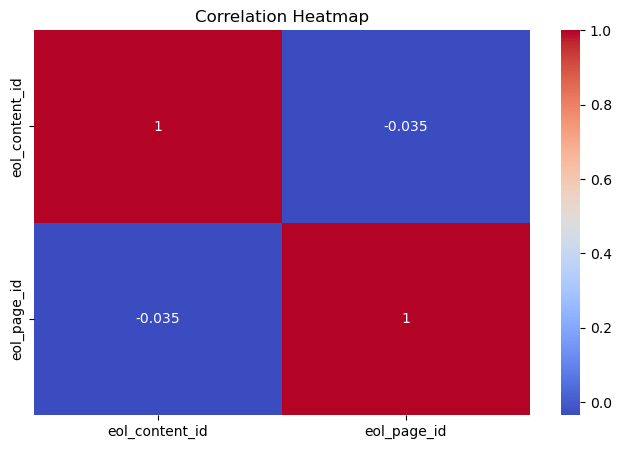

In [9]:
# Only include numeric fields
numeric_df = df.select_dtypes(include='number')

# Correlation heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


**Step 3:**

Split the Dataset

In [10]:
# 70% training, 15% validation, 15% test (with stratified sampling)
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['is_endangered'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['is_endangered'], random_state=42)

**Step 4:**

Preprocess and Augment Images

In [11]:
# Set target image size and batch size
img_size = (224, 224)
batch_size = 32

# Training generator with augmentation
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validation/test generator (no augmentation)
val_test_gen = ImageDataGenerator(rescale=1./255)

# Flow generators from DataFrame
train_data = train_gen.flow_from_dataframe(train_df, x_col='file_name', y_col='is_endangered',
                                           target_size=img_size, class_mode='binary', batch_size=batch_size, shuffle=True)

val_data = val_test_gen.flow_from_dataframe(val_df, x_col='file_name', y_col='is_endangered',
                                            target_size=img_size, class_mode='binary', batch_size=batch_size, shuffle=False)

test_data = val_test_gen.flow_from_dataframe(test_df, x_col='file_name', y_col='is_endangered',
                                             target_size=img_size, class_mode='binary', batch_size=batch_size, shuffle=False)


Found 8388 validated image filenames belonging to 2 classes.
Found 1797 validated image filenames belonging to 2 classes.
Found 1798 validated image filenames belonging to 2 classes.


**Step 5:**

Build the Model (MobileNetV2 Transfer Learning)

# EfficientNetB0 Model for Binary Classification

In this section, we use the **EfficientNetB0** architecture, pre-trained on ImageNet, as the base model for a binary classification task. The base model is frozen to prevent training of the pre-trained weights, and custom layers are added for the classification task.

### Model Overview:
1. **EfficientNetB0**: Pre-trained on ImageNet and used as the base model for feature extraction. The top classification layers are excluded.
2. **GlobalAveragePooling2D**: Reduces the spatial dimensions of the feature maps.
3. **Dropout Layer**: Added with a rate of 0.3 to prevent overfitting.
4. **Dense Layer**: Final output layer with a sigmoid activation function for binary classification.

### Model Compilation:
- **Optimizer**: Adam optimizer is used for training.
- **Loss Function**: Binary crossentropy is used for binary classification.
- **Metrics**: Accuracy is used as the evaluation metric.

This model is ready to be trained on binary classification tasks with image data.


In [12]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, GlobalAveragePooling2D, Dropout,
                                     Dense, BatchNormalization, RandomFlip,
                                     RandomRotation, RandomZoom)

# Data Augmentation Block
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
], name="data_augmentation")

# Input
input_layer = Input(shape=(224, 224, 3))

# Augmentation + Base Model
x = data_augmentation(input_layer)

# Load EfficientNetB0 without top
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=x)
base_model.trainable = False  # Freeze base

# Custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output_layer = Dense(1, activation='sigmoid')(x)

# Final model
efficient_net_model = Model(inputs=input_layer, outputs=output_layer)

In [13]:
# Compile
efficient_net_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train (initial phase)
history = efficient_net_model.fit(train_data, validation_data=val_data, epochs=10)

c:\Users\PC\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
126/263 ━━━━━━━━━━━━━━━━━━━━ 4:57 2s/step - accuracy: 0.5049 - loss: 0.9261

c:\Users\PC\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


263/263 ━━━━━━━━━━━━━━━━━━━━ 1306s 5s/step - accuracy: 0.5152 - loss: 0.8697 - val_accuracy: 0.5821 - val_loss: 0.6803
Epoch 2/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 650s 2s/step - accuracy: 0.5316 - loss: 0.7408 - val_accuracy: 0.5821 - val_loss: 0.6827
Epoch 3/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 9553s 36s/step - accuracy: 0.5340 - loss: 0.7243 - val_accuracy: 0.5821 - val_loss: 0.6797
Epoch 4/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 651s 2s/step - accuracy: 0.5475 - loss: 0.7052 - val_accuracy: 0.5821 - val_loss: 0.6799
Epoch 5/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 775s 3s/step - accuracy: 0.5562 - loss: 0.6993 - val_accuracy: 0.5821 - val_loss: 0.6794
Epoch 6/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 1747s 7s/step - accuracy: 0.5637 - loss: 0.6931 - val_accuracy: 0.5821 - val_loss: 0.6803
Epoch 7/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 998s 4s/step - accuracy: 0.5688 - loss: 0.6887 - val_accuracy: 0.5821 - val_loss: 0.6818
Epoch 8/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 13882s 53s/step - accuracy: 0.5720 - loss: 0.6863 - val_accuracy

In [14]:
# Evaluate on test set
loss, accuracy = efficient_net_model.evaluate(test_data)
print(f"Test Accuracy: {accuracy:.2f}")

# Generate predictions
preds = efficient_net_model.predict(test_data)
y_pred = (preds > 0.5).astype(int)
y_true = test_data.classes

# Classification report
print(classification_report(y_true, y_pred, target_names=['Not Endangered', 'Endangered']))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

57/57 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.5799 - loss: 0.6803
Test Accuracy: 0.58
57/57 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step
                precision    recall  f1-score   support

Not Endangered       0.58      1.00      0.74      1046
    Endangered       0.00      0.00      0.00       752

      accuracy                           0.58      1798
     macro avg       0.29      0.50      0.37      1798
  weighted avg       0.34      0.58      0.43      1798

Confusion Matrix:
 [[1046    0]
 [ 752    0]]


c:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


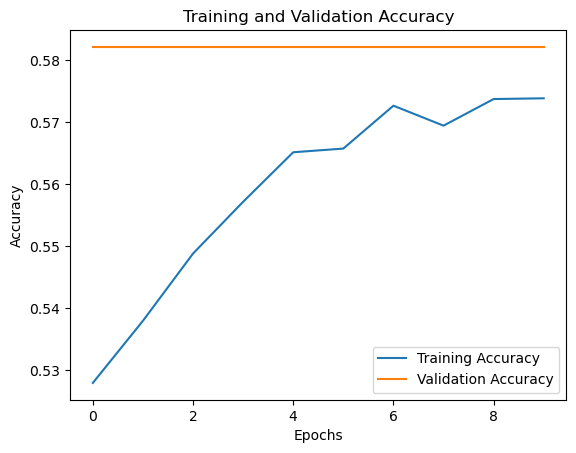

In [15]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [16]:


# 🔄 Fine-tuning: unfreeze top 20 layers of base_model
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Recompile with lower learning rate
efficient_net_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='binary_crossentropy', metrics=['accuracy'])

# Train (fine-tuning phase)
fine_tune_history = efficient_net_model.fit(train_data, validation_data=val_data, epochs=10)

Epoch 1/10
 93/263 ━━━━━━━━━━━━━━━━━━━━ 6:18 2s/step - accuracy: 0.5879 - loss: 0.6783

c:\Users\PC\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


263/263 ━━━━━━━━━━━━━━━━━━━━ 714s 3s/step - accuracy: 0.5807 - loss: 0.6814 - val_accuracy: 0.5821 - val_loss: 0.6817
Epoch 2/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 837s 3s/step - accuracy: 0.5774 - loss: 0.6826 - val_accuracy: 0.5821 - val_loss: 0.6815
Epoch 3/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 4828s 18s/step - accuracy: 0.5778 - loss: 0.6822 - val_accuracy: 0.5821 - val_loss: 0.6799
Epoch 4/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 988s 4s/step - accuracy: 0.5685 - loss: 0.6858 - val_accuracy: 0.5821 - val_loss: 0.6797
Epoch 5/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 952s 4s/step - accuracy: 0.5708 - loss: 0.6851 - val_accuracy: 0.5821 - val_loss: 0.6800
Epoch 6/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 967s 4s/step - accuracy: 0.5845 - loss: 0.6805 - val_accuracy: 0.5821 - val_loss: 0.6797
Epoch 7/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 1196s 5s/step - accuracy: 0.5758 - loss: 0.6814 - val_accuracy: 0.5821 - val_loss: 0.6801
Epoch 8/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 904s 3s/step - accuracy: 0.5740 - loss: 0.6836 - val_accuracy: 0.

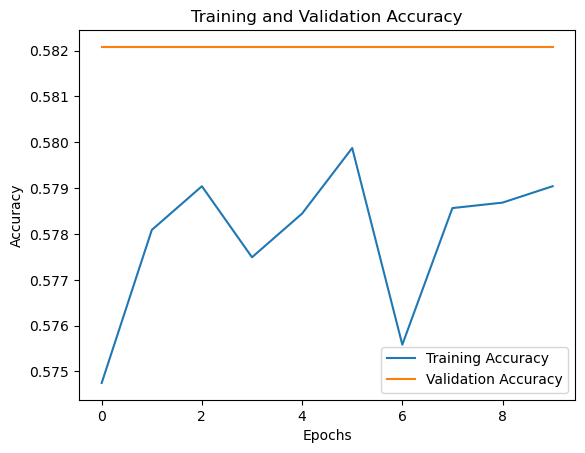

In [17]:
# Plot accuracy
plt.plot(fine_tune_history.history['accuracy'], label='Training Accuracy')
plt.plot(fine_tune_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Build a simple CNN model
model = Sequential([
    # Convolutional Block 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    # Convolutional Block 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    # Convolutional Block 3
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    # Flatten + Dense Layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary output
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Summary
model.summary()


c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 111, 111, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 54, 54, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 26, 26, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,985 (42.61 MB)

 Trainable params: 11,169,537 (42.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [19]:
history = model.fit(
    train_data,      
    validation_data=val_data,
    epochs=10,
    batch_size=32
)


Epoch 1/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 698s 3s/step - accuracy: 0.5206 - loss: 2.0299 - val_accuracy: 0.4201 - val_loss: 1.3395
Epoch 2/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 2143s 8s/step - accuracy: 0.5583 - loss: 1.2561 - val_accuracy: 0.5593 - val_loss: 1.0483
Epoch 3/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 975s 4s/step - accuracy: 0.5495 - loss: 1.1060 - val_accuracy: 0.5643 - val_loss: 0.9800
Epoch 4/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 990s 4s/step - accuracy: 0.5719 - loss: 0.9879 - val_accuracy: 0.5654 - val_loss: 1.0006
Epoch 5/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 1023s 4s/step - accuracy: 0.5923 - loss: 0.8699 - val_accuracy: 0.5682 - val_loss: 0.9252
Epoch 6/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 830s 3s/step - accuracy: 0.5870 - loss: 0.8002 - val_accuracy: 0.5737 - val_loss: 0.8859
Epoch 7/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 865s 3s/step - accuracy: 0.6021 - loss: 0.7403 - val_accuracy: 0.5954 - val_loss: 0.7428
Epoch 8/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 870s 3s/step - accuracy: 0.6106 - loss: 0.6971 - val_ac

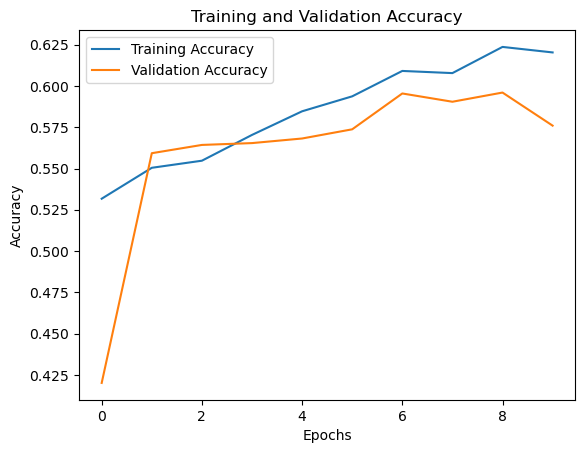

In [20]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [21]:
# Evaluate on test set
loss, accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {accuracy:.2f}")

# Generate predictions
preds = model.predict(test_data)
y_pred = (preds > 0.5).astype(int)
y_true = test_data.classes

# Classification report
print(classification_report(y_true, y_pred, target_names=['Not Endangered', 'Endangered']))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

57/57 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.5984 - loss: 0.7534
Test Accuracy: 0.59
57/57 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step
                precision    recall  f1-score   support

Not Endangered       0.62      0.76      0.68      1046
    Endangered       0.52      0.36      0.42       752

      accuracy                           0.59      1798
     macro avg       0.57      0.56      0.55      1798
  weighted avg       0.58      0.59      0.57      1798

Confusion Matrix:
 [[796 250]
 [485 267]]


In [22]:
# Load pre-trained MobileNetV2 model (excluding top layer)
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification

# Construct final model
model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

**Step 6:**

Train the Model

In [23]:
# Train for 10 epochs
history = model.fit(train_data, validation_data=val_data, epochs=10)

Epoch 1/10
219/263 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - accuracy: 0.5525 - loss: 0.7557

c:\Users\PC\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


263/263 ━━━━━━━━━━━━━━━━━━━━ 700s 3s/step - accuracy: 0.5575 - loss: 0.7501 - val_accuracy: 0.6416 - val_loss: 0.6322
Epoch 2/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 604s 2s/step - accuracy: 0.6340 - loss: 0.6626 - val_accuracy: 0.6689 - val_loss: 0.6108
Epoch 3/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 714s 3s/step - accuracy: 0.6511 - loss: 0.6309 - val_accuracy: 0.6416 - val_loss: 0.6487
Epoch 4/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 714s 3s/step - accuracy: 0.6539 - loss: 0.6402 - val_accuracy: 0.6767 - val_loss: 0.6066
Epoch 5/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 660s 3s/step - accuracy: 0.6589 - loss: 0.6224 - val_accuracy: 0.6706 - val_loss: 0.6049
Epoch 6/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 681s 3s/step - accuracy: 0.6660 - loss: 0.6134 - val_accuracy: 0.6750 - val_loss: 0.6046
Epoch 7/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 711s 3s/step - accuracy: 0.6797 - loss: 0.6062 - val_accuracy: 0.6867 - val_loss: 0.5987
Epoch 8/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 684s 3s/step - accuracy: 0.6700 - loss: 0.6080 - val_accuracy: 0.678

**Step 7:**

Evaluate Performance

In [24]:
# Evaluate on test set
loss, accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {accuracy:.2f}")

# Generate predictions
preds = model.predict(test_data)
y_pred = (preds > 0.5).astype(int)
y_true = test_data.classes

# Classification report
print(classification_report(y_true, y_pred, target_names=['Not Endangered', 'Endangered']))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

57/57 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.6838 - loss: 0.5855
Test Accuracy: 0.68
57/57 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step
                precision    recall  f1-score   support

Not Endangered       0.71      0.74      0.73      1046
    Endangered       0.62      0.59      0.60       752

      accuracy                           0.68      1798
     macro avg       0.67      0.66      0.66      1798
  weighted avg       0.67      0.68      0.67      1798

Confusion Matrix:
 [[772 274]
 [309 443]]


**Step 8:**

Plot Accuracy and Loss

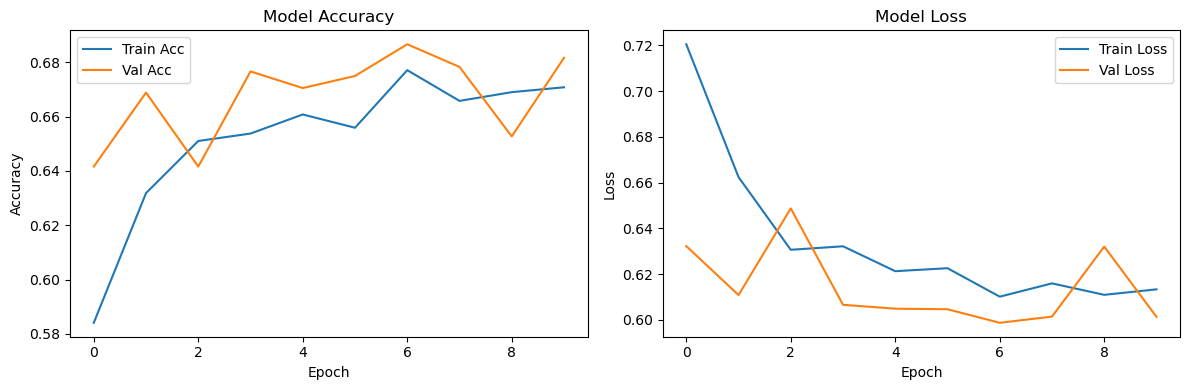

In [25]:
# Plot training and validation accuracy/loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

**Step 9:**

Visualize with Grad-CAM

**Grad-CAM Helper Functions**

In [26]:
# Generate Grad-CAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name="Conv_1", pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs], 
                                       [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Overlay Grad-CAM heatmap on image
def overlay_heatmap(heatmap, img, alpha=0.4, colormap=cv2.COLORMAP_JET):
    heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_colored = cv2.applyColorMap(heatmap, colormap)
    img_np = np.array(img)
    superimposed_img = cv2.addWeighted(img_np, 1 - alpha, heatmap_colored, alpha, 0)
    return superimposed_img

# Load and preprocess image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img, img_array

**Apply Grad-CAM to a Sample Image**

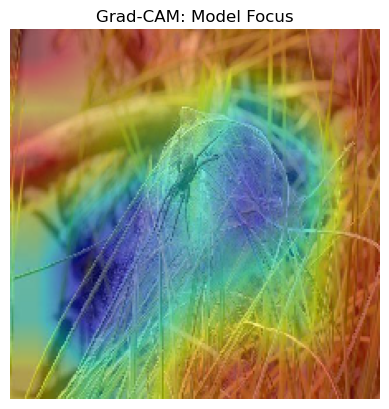

In [56]:
# Path to a test image
img_path = 'C:/Users/PC/Desktop/wild-life-conservation/test_data/img4.jpg'
img, img_array = preprocess_image(img_path)
# Generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name="Conv_1")
# Overlay heatmap
superimposed_img = overlay_heatmap(heatmap, img)
# Show image
plt.imshow(superimposed_img)
plt.title("Grad-CAM: Model Focus")
plt.axis('off')
plt.show()


In [57]:
# Make prediction
prediction = model.predict(img_array)

# Interpret result
if prediction[0][0] > 0.5:
    print("Predicted: Endangered Species 🌍")
else:
    print("Predicted: Not Endangered ❌")

# Optional: show probability
print(f"Endangered probability: {prediction[0][0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Predicted: Endangered Species 🌍
Endangered probability: 0.67


In [55]:
# Make prediction
prediction = efficient_net_model.predict(img_array)

# Interpret result
if prediction[0][0] > 0.5:
    print("Predicted: Endangered Species 🌍")
else:
    print("Predicted: Not Endangered ❌")

# Optional: show probability
print(f"Endangered probability: {prediction[0][0]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
Predicted: Not Endangered ❌
Endangered probability: 0.45


In [59]:
model.save('monilenet.h5')

In [67]:
from tensorflow.keras.models import load_model

# load model 
mobilenet = load_model("mobilenet.h5")


In [73]:
img_path = 'C:/Users/PC/Desktop/wild-life-conservation/test_data/img4.jpg'
img, img_array = preprocess_image(img_path)

In [74]:
# Make prediction
prediction = mobilenet.predict(img_array)

# Interpret result
if prediction[0][0] > 0.5:
    print("Predicted: Endangered Species 🌍")
else:
    print("Predicted: Not Endangered ❌")

# Optional: show probability
print(f"Endangered probability: {prediction[0][0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
Predicted: Endangered Species 🌍
Endangered probability: 0.67


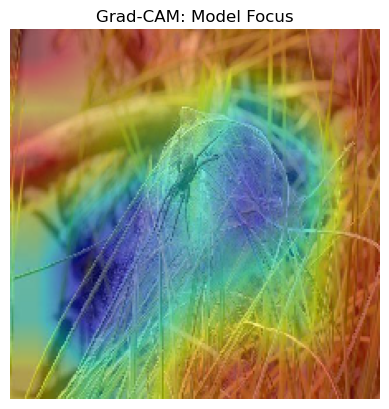

In [75]:
# Generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name="Conv_1")
# Overlay heatmap
superimposed_img = overlay_heatmap(heatmap, img)
# Show image
plt.imshow(superimposed_img)
plt.title("Grad-CAM: Model Focus")
plt.axis('off')
plt.show()

In [61]:
# Make prediction
prediction = my_model.predict(img_array)

# Interpret result
if prediction[0][0] > 0.5:
    print("Predicted: Endangered Species 🌍")
else:
    print("Predicted: Not Endangered ❌")

# Optional: show probability
print(f"Endangered probability: {prediction[0][0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted: Endangered Species 🌍
Endangered probability: 0.72
